In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from cvxpower import *

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#from config import *

In [2]:
load1 = FixedLoad(power=50, name="load1")
load2 = FixedLoad(power=100, name="load2")

gen1 = Generator(power_max=1000, alpha=0.02, beta=30, name="gen1")
gen2 = Generator(power_max=100, alpha=0.2, beta=0, name="gen2")

line1 = TransmissionLine(power_max=50, name='line1')
line2 = TransmissionLine(power_max=10, name='line2')
line3 = TransmissionLine(power_max=50, name='line3')

net1 = Net([load1.terminals[0], gen1.terminals[0], 
            line1.terminals[0], line2.terminals[0]], name = 'net1')
net2 = Net([load2.terminals[0], line1.terminals[1], 
            line3.terminals[0]], name = 'net2')
net3 = Net([gen2.terminals[0], line2.terminals[1], 
            line3.terminals[1]], name = 'net3')
network = Group([load1, load2, gen1, gen2,
    line1, line2, line3],
    [net1, net2, net3])

network.init_problem()
network.optimize(solver='ECOS')
print(network.results.summary())

Status: optimal
Terminal                  Power
--------                  -----
load1[0]                  50.00
load2[0]                 100.00
gen1[0]                  -90.00
gen2[0]                  -60.00
line1[0]                  50.00
line1[1]                 -50.00
line2[0]                 -10.00
line2[1]                  10.00
line3[0]                 -50.00
line3[1]                  50.00

Net                       Price
---                       -----
net1                    33.6000
net2                   199.5965
net3                    24.0012

Device                  Payment
------                  -------
load1                   1680.00
load2                  19959.65
gen1                   -3024.00
gen2                   -1440.07
line1                  -8299.83
line2                    -95.99
line3                  -8779.76

Power and price are averages over the time horizon. Payment is total.



In [5]:
flows = pd.Series()
dir(network.results)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'payments',
 'plot',
 'power',
 'price',
 'status',
 'summary']

In [64]:
network.results.price

{<cvxpower.network.Net at 0xb1dadddd8>: array([[24.00116919]]),
 <cvxpower.network.Net at 0xb1dadde48>: array([[33.59995155]]),
 <cvxpower.network.Net at 0xb1dadde80>: array([[199.59646122]])}

In [50]:
import pandas as pd
flows = pd.DataFrame(columns=['terminal 1', 'terminal 2'])
for (device, terminal) in network.results.power.keys():
    flows.loc[device.name, 'terminal %d' % (terminal +1)] = network.results.power[(device, terminal)][0][0]
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.0fMW' % x))

\begin{tabular}{lll}
\toprule
{} & terminal 1 & terminal 2 \\
\midrule
load1 &       50MW &          - \\
load2 &      100MW &          - \\
gen1  &      -90MW &          - \\
gen2  &      -60MW &          - \\
line1 &       50MW &      -50MW \\
line2 &      -10MW &       10MW \\
line3 &      -50MW &       50MW \\
\bottomrule
\end{tabular}



In [ ]:
import pandas as pd
prices = pd.DataFrame(columns=['price'])
for (device, terminal) in network.results.power.keys():
    flows.loc[device.name, 'terminal %d' % (terminal +1)] = network.results.power[(device, terminal)][0][0]
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.0fMW' % x))

In [63]:
payments = pd.DataFrame(columns=['terminal 1', 'terminal 2', 'total'])
for (device, terminal) in network.results.payments.keys():
    payments.loc[device.name, 'terminal %d' % (terminal +1)] = network.results.payments[(device, terminal)][0][0]

payments['total'] = payments.iloc[:,:2].sum(1)
print(payments.to_latex(na_rep = '-', float_format=lambda x: ('-' if np.sign(x) < 0 else '') + '$%.0f' % np.abs(x)))

\begin{tabular}{lllr}
\toprule
{} & terminal 1 & terminal 2 &  total \\
\midrule
load1 &      \$1680 &          - &  \$1680 \\
load2 &     \$19960 &          - & \$19960 \\
gen1  &     -\$3024 &          - & -\$3024 \\
gen2  &     -\$1440 &          - & -\$1440 \\
line1 &      \$1680 &     -\$9980 & -\$8300 \\
line2 &      -\$336 &       \$240 &   -\$96 \\
line3 &     -\$9980 &      \$1200 & -\$8780 \\
\bottomrule
\end{tabular}



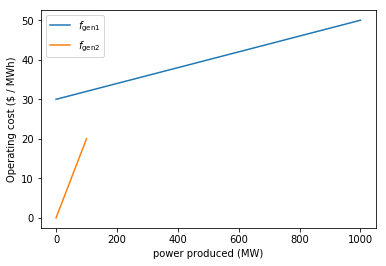

In [3]:
alpha1, beta1, pmax1 = 0.02, 30, 1000
alpha2, beta2, pmax2 = 0.2, 0, 100

#plt.figure(figsize=FIGREGULAR)
xs = np.linspace(0.001,pmax1)
plt.plot(xs, (alpha1*xs**2 + beta1*xs)/xs, label=r'$f_{\rm gen1}$')
xs = np.linspace(0.001,pmax2)
plt.plot(xs, (alpha2*xs**2 + beta2*xs)/xs, label=r'$f_{\rm gen2}$')
plt.legend()
plt.xlabel(r'power produced (MW)')
plt.ylabel(r'Operating cost ($ / MWh)')
#plt.xlim([0, 1000])
#plt.ylim([0, max(pmax1, pmax2)])
plt.savefig("three_bus_gen_cost.pdf")

In [24]:
# load1 = FixedLoad(power=50, name="load1")
# load2 = FixedLoad(power=100, name="load2")

# gen1 = Generator(power_max=1000,
#   alpha=0.01, beta=100, name="gen1")
# gen2 = Generator(power_max=100, alpha=0.1,
#   beta=0.1, name="gen2")

# line1 = TransmissionLine(power_max=50, name = 'line1', alpha=0.001)
# #line1 = TransmissionLine(name = 'line1', alpha=0.001)
# line2 = TransmissionLine(power_max=10, name = 'line2')
# line3 = TransmissionLine(power_max=50, name = 'line3')

# net1 = Net([load1.terminals[0],
#     gen1.terminals[0], line1.terminals[0],
#     line2.terminals[0]], name = 'net1')
# net2 = Net([load2.terminals[0], line1.terminals[1], 
#     line3.terminals[0]], name = 'net2')
# net3 = Net([gen2.terminals[0], line2.terminals[1], 
#     line3.terminals[1]], name = 'net3')
# network = Group([load1, load2, gen1, gen2,
#     line1, line2, line3],
#     [net1, net2, net3])

# network.init_problem()
# network.optimize()
# print(network.results.summary())